<a href="https://colab.research.google.com/github/kiranmuloor/DataScience/blob/master/CNN/Keras_cats_dogs_convnet_pretrained_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#This method does not use Data Augmentation
from keras.applications import VGG16
#Just reuse the bottom convolutional base of VGG16 model as its more generic, top will be related to specific classes so not used
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Extracting features using the pretrained convolutional base
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir = '/content/drive/My Drive/Datascience/ClassWork/DeepLearning/CNN/dogs-vs-cats_small/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'validation')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        #print(labels_batch.shape)
        i += 1
        #Note that because generators yield data indefinitely in a loop,you must break after every image has been seen once
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 3000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
#The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them
#to a densely connected classifier, so first you must flatten them to (samples, 8192):

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [5]:
# Defining and Training the Densely connected classifier
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5942 - acc: 0.6805 - val_loss: 0.4412 - val_acc: 0.8150
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4244 - acc: 0.8085 - val_loss: 0.3643 - val_acc: 0.8430
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3533 - acc: 0.8470 - val_loss: 0.3290 - val_acc: 0.8610
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3007 - acc: 0.8840 - val_loss: 0.3245 - val_acc: 0.8490
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2796 - acc: 0.8875 - val_loss: 0.2959 - val_acc: 0.8710
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2618 - acc: 0.9000 - val_loss: 0.2861 - val_acc: 0.8750
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2414 - acc: 0.9105 - val_loss: 0.2807 - val_acc: 0.8730
Epoch 8/30
200

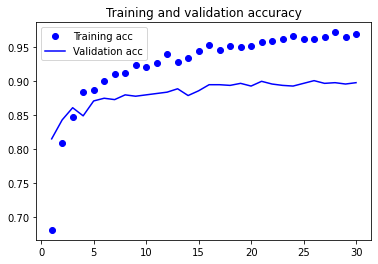

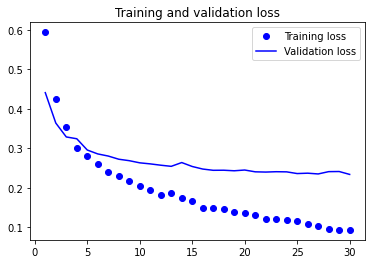

In [6]:
#Plotting the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()